# Load Relevant Libraries

In [1]:
# For Spark and SparkSQL
import pyspark
from pyspark.sql.types import StructType,StructField, StringType, IntegerType,BooleanType,DoubleType,DateType
import pandas as pd
from pyspark.sql.functions import col,when,count,udf,length,isnan,monotonically_increasing_id
from pyspark.sql.functions import sum as _sum
from pyspark.sql import DataFrameStatFunctions as statFunc

# For data manipulation or checking the file system for extant files
from datetime import datetime
import numpy as np
import os
import shutil

# For data exploration
from pyspark_dist_explore import Histogram, hist, distplot, pandas_histogram
import matplotlib.pyplot as plt
import seaborn as sns

# Needed to show values in non-scientific format.
np.set_printoptions(suppress=True)
pd.set_option('precision', 4)
import warnings
warnings.filterwarnings('ignore', '.*do not.*', )
warnings.warn('DelftStack')
warnings.warn('Do not show this message')

/tmp/ipykernel_9477/4205886303.py:25: UserWarning: DelftStack
  warnings.warn('DelftStack')


 **Making sure that this instance of Spark runs on all the cores on the machine.**

In [2]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
#spark=SparkSession.builder.getOrCreate()
sc = pyspark.SparkContext("local[*]", "project", )
spark = SparkSession(sc)

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/03/30 17:56:52 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# Data Loading

## Convert to parquet file format
Reading the data from a very large CSV file will be incredibly slow, especially for a system based off on a hard disk drive. We convert the data format to parquet, which loads around a thousand times faster.

In [6]:
if not os.path.exists("/home/kingleozohaib2407/spark-project/par.parq/"):
    # Quotes are escaped using quotes itself, and the schema is inferred on first run.
    df = spark.read.format("csv").\
        options(header=True, sep="|",
                inferSchema=True, escape='"').\
        load("full_data.csv")
    # Written as a compressed data file using Facebook's zstd to save space.
    df.write.parquet("par.parq", compression="zstd")

All further analysis is done on the parquet file.

In [7]:
df = spark.read.parquet("par.parq")
df

DataFrame[name: string, author: string, removed_by_category: string, allow_live_comments: string, top_awarded_type: string, is_video: int, edited: string, is_self: string, author_flair_text: string, thumbnail: string, suggested_sort: string, link_flair_background_color: string, hidden: double, can_gild: string, wls: string, subreddit_type: string, num_comments: int, total_awards_received: int, media_only: string, link_flair_richtext: string, upvote_ratio: double, author_flair_css_class: string, all_awardings: string, discussion_type: string, score: string, quarantine: int, created_utc: string, spoiler: int, category: string, id: string, num_crossposts: string, send_replies: int, domain: string, gilded: int, media: string, thumbnail_height: string, author_flair_text_color: string, permalink: string, author_flair_template_id: string, locked: string, link_flair_text: string, no_follow: int, whitelist_status: string, link_flair_css_class: string, media_embed: string, subreddit_subscribers:

## Data Cleaning 

**Here we apply different methodologies to clean the data and bring it into a concise format for further exploration and modelling**

In [6]:
df.groupBy('author_flair_text_color').count().sort('count', ascending=False).collect()

[Row(author_flair_text_color=None, count=25327057),
 Row(author_flair_text_color='dark', count=8323468),
 Row(author_flair_text_color='light', count=467964),
 Row(author_flair_text_color='{}', count=13),
 Row(author_flair_text_color='{\'content\': \'&lt;iframe width="356" height="200" src="https://www.youtube.com/embed/Br5ayAkgs4g?feature=oembed&amp;enablejsapi=1" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen&gt;&lt;/iframe&gt;\', \'height\': 200, \'scrolling\': False, \'width\': 356}', count=1),
 Row(author_flair_text_color='{\'content\': \'&lt;iframe width="356" height="200" src="https://www.youtube.com/embed/PgTgias1alI?feature=oembed&amp;enablejsapi=1" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen&gt;&lt;/iframe&gt;\', \'height\': 200, \'scrolling\': False, \'width\': 356}', count=1),
 Row(author_flair_text_color='{\'c

**Keep only columns of interest**

In [8]:
col_names = [
    "author", "subreddit", "score", "subreddit_subscribers", "over_18",
    "distinguished", "num_crossposts", "is_video", "num_comments",
    "is_self", "thumbnail", "domain", "created_utc", "is_crosspostable",
    "is_original_content", "total_awards_received", "upvote_ratio",
    # Added by Avinash after Zohaib's transfer from R to Python
    "author_flair_background_color", "is_created_from_ads_ui",
    "title", "media_embed"]

# Select only the columns specified above
df_n = df.select(col_names)

**Casting different columns to valid formats**

In [9]:
# Change the data types of these columns
df_n1 = df_n.\
    withColumn("author",col("author").cast(StringType())) \
   .withColumn("subreddit",col("subreddit").cast(StringType())) \
   .withColumn("score",col("score").cast(IntegerType())) \
   .withColumn("subreddit_subscribers",col("subreddit_subscribers").cast(IntegerType())) \
   .withColumn("over_18",col("over_18").cast(BooleanType())) \
   .withColumn("distinguished",col("distinguished").cast(StringType())) \
   .withColumn("num_crossposts",col("num_crossposts").cast(IntegerType())) \
   .withColumn("is_video",col("is_video").cast(BooleanType())) \
   .withColumn("num_comments",col("num_comments").cast(IntegerType())) \
   .withColumn("is_self",col("is_self").cast(BooleanType())) \
   .withColumn("thumbnail",col("thumbnail").cast(StringType())) \
   .withColumn("domain",col("domain").cast(StringType())) \
   .withColumn("is_crosspostable",col("is_crosspostable").cast(BooleanType())) \
   .withColumn("is_original_content",col("is_original_content").cast(BooleanType())) \
   .withColumn("created_utc",col("created_utc").cast(IntegerType())) \
   .withColumn("total_awards_received",col("total_awards_received").cast(IntegerType())) \
   .withColumn("upvote_ratio",col("upvote_ratio").cast(IntegerType()))

## Cleaning more columns

When posts are deleted on Reddit, their author names are marked under "[deleted]". This will be construed as a common poster across almost every subreddit, which we want to avoid. While coding the data from the JSON file to CSV, we coded these as `null` values.

In [10]:
df_n1 = df_n1.na.drop(subset=["author"])
df_n1.count()

27773188

*_That's around $28$ million records. Let's choose subreddits with at least $353,518$ subscribers - that is, around the top $20\%$ of all subreddits in the data._*

In [11]:
# The below variable is to check to see if the quantile makes sense:
ss = statFunc(df_n1).approxQuantile( "subreddit_subscribers", [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9], 0.01)

# Filtering for the minimum subscriber count
df_n2 = df_n1.filter(df_n1.subreddit_subscribers>=353518)
df_n2.count()

5554869

*_This brings the record count to under 6 million, which is still a significant amount. The next step is to check the number of non-null columns in the data, and change the columns that are to some other value._*

In [12]:
df_n2.select([count(when(col(c).isNotNull() , c)).alias(c) for c in df_n2.columns]).toPandas()

,author,subreddit,score,subreddit_subscribers,over_18,distinguished,num_crossposts,is_video,num_comments,is_self,...,domain,created_utc,is_crosspostable,is_original_content,total_awards_received,upvote_ratio,author_flair_background_color,is_created_from_ads_ui,title,media_embed
0,5554869,5554869,5554869,5554869,5554869,2228,5554869,5554869,5554869,5554869,...,5554860,5554869,5554869,5554869,5554869,5554869,294996,5554869,5554856,5554869


*_Looks like only `distinguished` has a limited number of non-null values, making is less useful for modelling. This column can be dropped as so:_*

In [13]:
df_n2 = df_n2.drop('distinguished')

*_The next step is to start cleaning columns. The `created_utc` column currently shows the number of seconds since the Unix epoch, and to make this useful for modelling, the column needs to be converted to a timestamp, as done so below._*

In [14]:
def convert_to_utc(date):
    ts = datetime.utcfromtimestamp(date).strftime('%Y-%m-%d %H:%M:%S')
    return ts

udf_convert_to_utc = udf(lambda x:convert_to_utc(x))
df_n3=df_n2.withColumn('created_datetime',udf_convert_to_utc(col(('created_utc')))).select('*')

*_An additional filter - a minimum score of $2$ is needed to make sure that posts with positive upvote - downvote values are included, with another minimum requirement that at least **two** other users have liked the post aside from the one that posted the content (i.e. the OP)._*

In [15]:
# Quantile calculation
sc = statFunc(df_n3).approxQuantile( "score", [0.1,0.2,0.3,0.4,0.5], 0.25)
print(sc)

# Filtering for a minimum score
df_n3 = df_n3.filter(df_n3.score>2)

[0.0, 0.0, 1.0, 2.0, 3.0]


Adding more calculated columns:

In [16]:
df_n3

DataFrame[author: string, subreddit: string, score: int, subreddit_subscribers: int, over_18: boolean, num_crossposts: int, is_video: boolean, num_comments: int, is_self: boolean, thumbnail: string, domain: string, created_utc: int, is_crosspostable: boolean, is_original_content: boolean, total_awards_received: int, upvote_ratio: int, author_flair_background_color: string, is_created_from_ads_ui: int, title: string, media_embed: string, created_datetime: string]

In [17]:
df_n3.withColumn(
    'author_flair', when(col('author_flair_background_color') == 'transparent', 'transparent').\
    when(col('author_flair_background_color').isNotNull(), 'coloured').\
    otherwise('none'))

DataFrame[author: string, subreddit: string, score: int, subreddit_subscribers: int, over_18: boolean, num_crossposts: int, is_video: boolean, num_comments: int, is_self: boolean, thumbnail: string, domain: string, created_utc: int, is_crosspostable: boolean, is_original_content: boolean, total_awards_received: int, upvote_ratio: int, author_flair_background_color: string, is_created_from_ads_ui: int, title: string, media_embed: string, created_datetime: string, author_flair: string]

In [18]:
# Adding a boolean is_thumbnail 
df_n3 = df_n3.withColumn('is_thumbnail', when(col('thumbnail').isNotNull(), 1).otherwise(0))
 
# Adding a media embedded booelan
df_n3 = df_n3.withColumn('is_media_embed', when(col('media_embed')=='{}', 1).otherwise(0))

# Changing a ads based UI creation flag
df_n3 = df_n3.withColumn(
    'is_created_from_ads_ui',
    when(col('is_created_from_ads_ui').isNull(), 0).\
    otherwise(col('is_created_from_ads_ui')))

# Adding a author flair colour tri-lean?
df_n3 = df_n3.withColumn(
    'author_flair',
    when(col('author_flair_background_color') == 'transparent', 'transparent').\
    when(col('author_flair_background_color').isNotNull(), 'coloured').\
    otherwise('none'))

# Adding a number of characters in title column
df_n3 = df_n3.withColumn('title_length', length(col('title')))

# Drop unused columns
df_n3 = df_n3.drop('thumbnail','created_utc', 'title', 'media_embed')

Filter for having a minimum number of posts per month i.e. being an *active* subreddit.

In [19]:
# Create the subreddit post count
df_n4 = df_n3.groupBy('subreddit').count().select('subreddit', col('count').alias('n'))
df_n4 = df_n4.filter(df_n4.n>=8)

# Subreddit names, join against post count calculated above
subreds = df_n4.select('subreddit')
df_n5 = df_n3.join(subreds,df_n4.subreddit==subreds.subreddit,"leftsemi")

df_n5.count()

2880059

*_There are around 3 million records in this file, which can be further worked with on Spark. Finally, writing the new data to disk as a parquet file._*

In [19]:
# Write data to disk
if os.path.exists("/home/kingleozohaib2407/spark-project/df_subset.parquet"):
    shutil.rmtree("/home/kingleozohaib2407/spark-project/df_subset.parquet")
df_n5.write.parquet("/home/kingleozohaib2407/spark-project/df_subset.parquet", compression="zstd")

# Data Exploration

Load the data cleaned hereforth into `pandas` and into a new Spark `DataFrame`. `pandas` is used for easier manipulation. Both packages support reading from parquet files directly, and are pretty fast.

In [44]:
cleaned_df = spark.read.parquet("df_subset.parquet")
df_pd = pd.read_parquet("df_subset.parquet")

#### Quick head of the data

In [21]:
df_pd.head()

,author,subreddit,score,subreddit_subscribers,over_18,num_crossposts,is_video,num_comments,is_self,domain,...,is_original_content,total_awards_received,upvote_ratio,author_flair_background_color,is_created_from_ads_ui,created_datetime,is_thumbnail,is_media_embed,author_flair,title_length
0,iChargePerReply,TrueOffMyChest,13,944767,False,0,False,10,True,self.TrueOffMyChest,...,False,0,0,None,0,2021-06-12 20:45:35,1,1,none,95.0
1,aimeee0,anime,5,2515198,False,0,False,24,True,self.anime,...,False,0,0,#02a9ff,0,2021-06-12 20:56:01,1,1,coloured,55.0
2,ThrowRA24000,TrueOffMyChest,6,944767,False,0,False,2,True,self.TrueOffMyChest,...,False,0,0,None,0,2021-06-12 20:58:19,1,1,none,56.0
3,zerofoxgivn,Amateur,3,1120219,True,0,False,1,False,imgur.com,...,False,0,1,None,0,2021-06-12 21:02:44,1,0,none,31.0
4,PonzuBees,anime,3,2515199,False,0,False,10,True,self.anime,...,False,0,0,None,0,2021-06-12 21:03:16,1,1,none,32.0


## Basic Summary Statistics
The $\mu$, $n$, $\sigma$, $\min$, $\max$ and percentiles, with an additional view of $0.9, 0.95$ and $0.99$.

In [22]:
df_pd.describe(percentiles=[0, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99])

,score,subreddit_subscribers,num_crossposts,num_comments,total_awards_received,upvote_ratio,is_created_from_ads_ui,is_thumbnail,is_media_embed,title_length
count,2.8801e+06,2.8801e+06,2.8801e+06,2.8801e+06,2.8801e+06,2.8801e+06,2880059.0,2880059.0,2.8801e+06,2.8801e+06
mean,4.5175e+02,4.0523e+06,1.2871e-01,2.4473e+01,8.6548e-01,1.6486e-01,0.0,1.0,9.3709e-01,5.0438e+01
std,3.0700e+03,7.8505e+06,9.4744e-01,2.5526e+02,1.0125e+01,3.7106e-01,0.0,0.0,2.4279e-01,4.3260e+01
min,3.0000e+00,3.5352e+05,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0,1.0,0.0000e+00,1.0000e+00
0%,3.0000e+00,3.5352e+05,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0,1.0,0.0000e+00,1.0000e+00
25%,7.0000e+00,5.3588e+05,0.0000e+00,2.0000e+00,0.0000e+00,0.0000e+00,0.0,1.0,1.0000e+00,2.3000e+01
50%,2.2000e+01,9.1814e+05,0.0000e+00,4.0000e+00,0.0000e+00,0.0000e+00,0.0,1.0,1.0000e+00,3.8000e+01
75%,7.7000e+01,2.5544e+06,0.0000e+00,1.2000e+01,0.0000e+00,0.0000e+00,0.0,1.0,1.0000e+00,6.3000e+01
90%,3.7100e+02,1.5686e+07,0.0000e+00,3.5000e+01,1.0000e+00,1.0000e+00,0.0,1.0,1.0000e+00,9.9000e+01
95%,1.2160e+03,2.7497e+07,1.0000e+00,7.5000e+01,2.0000e+00,1.0000e+00,0.0,1.0,1.0000e+00,1.3200e+02


### Summary of the observations in the above table:
1. Score primarily varies from $3$ to around $230,000$, with over $90\%$ of the data being under $371$.
2. Subreddit subcribes are significantly higher in magnitude, with a median value of $91,000$.
3. Crossposts are largely $0$, even to the $99\%$ile range.
4. Comment interactions are above $4$ only beyond the $50\%$ mark.
5. Awards recieved is strongly tied to the score of the post (higher scores get higher awards, especially at the top, and are likely cases of data leakage.
6. The `ads_ui` flag is practically irrelevant.
7. All posts have the `thumbnail` flag as `True`, so it is also not helpful in getting noticed.
8. Almost $80\%$ of posts have some form of Media Embedding.
9. The title length averages at $38$ characters (in terms of median).

As a consequence, the columns `is_thumbnail` and `is_created_from_ads_ui` is dropped.

In [23]:
df_pd = df_pd.drop(['is_thumbnail', 'is_created_from_ads_ui'], axis=1)

## Correlation Plots

Just the ol' run-of-the-mill correlation charts.

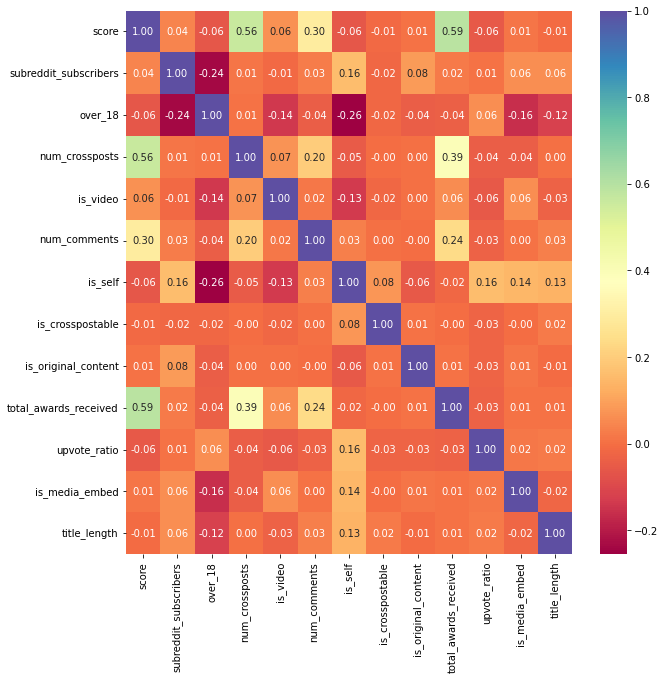

In [24]:
plt.figure(figsize=(10, 10))
sns.heatmap(df_pd.corr(),annot=True,cmap=sns.color_palette("Spectral", as_cmap=True), fmt=".2f");

#### Observations from the correlation plot:
1. The `total_awards_recieved` is, as observed earlier, highly correlated ($0.56$) to the `score`, and is a clear case of data leakage.
2. `score` and `num_crossposts` are also correlated ($0.56$), however, they drive each other, and is not as clear a case of data leakage, and can thus still be included in the model.
3. `score` is loosely tied to `num_comments` ($0.13$), and has a similar reasoning as `num_crossposts`.
4. There is a general negative correlation all "positive" measures of popularity (subscriber count, `is_video`, `is_self`, `title_length` etc.) with the adult-content flag, `over_18`, but does not have any linear relationship to `score`.


**All in all**, there is no clear linear relationship between the independent variable, the score, to the dependent variables, and therefore, more advanced machine learning techniques need to be utilized to understand some relationship between the two.

### Adding additional time-based measures

The following functions are designed to get specific periods such as the weekday, or hour of the data into a new column from the `datetime` field.

In [25]:
import calendar
def dates(x):
    return datetime.strptime(x, '%Y-%m-%d %H:%M:%S')

def get_date(date):
    return date.split(' ')[0]

def get_time(date):
    return date.split(' ')[1]

def get_weekday(date):
    date = datetime.strptime(date, '%Y-%m-%d')
    return calendar.day_name[date.weekday()]

In [26]:
df_pd['created_timestamp']   = df_pd['created_datetime'].apply(dates)
df_pd['created_date']        = df_pd['created_datetime'].apply(get_date)
df_pd['created_time']        = df_pd['created_datetime'].apply(get_time)
df_pd['created_weekday']     = df_pd['created_date'].apply(get_weekday)
df_pd['created_hour_of_day'] = df_pd['created_timestamp'].dt.hour

### Plots of categorial variables against the `score`

#### Weekday and Time of Day plots

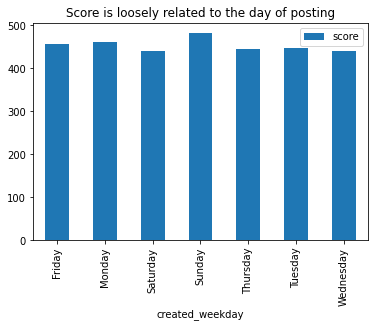

In [27]:
df_pd.groupby('created_weekday').agg({'score': np.mean}).\
    plot.bar(title="Score is loosely related to the day of posting");

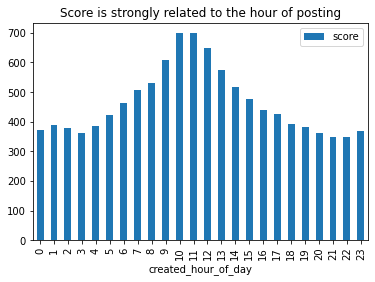

In [28]:
df_pd.groupby('created_hour_of_day').agg({'score': np.mean}).\
    plot.bar(title="Score is strongly related to the hour of posting");

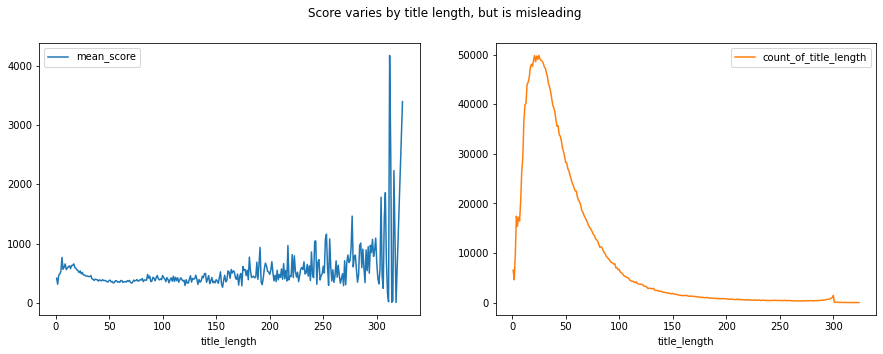

In [29]:
df_pd.groupby('title_length').\
    agg(mean_score=('score', 'mean'),
        count_of_title_length=('title_length', 'count')).\
    plot(subplots=True, title="Score varies by title length, but is misleading",
         layout=(1, 2), figsize=(15, 5));

While it may be easy to conclude that mean score increases by title length, there are far fewer titles with very high title length. To avoid misleading images, a plot for `title_length` values less than $100$ is in order:

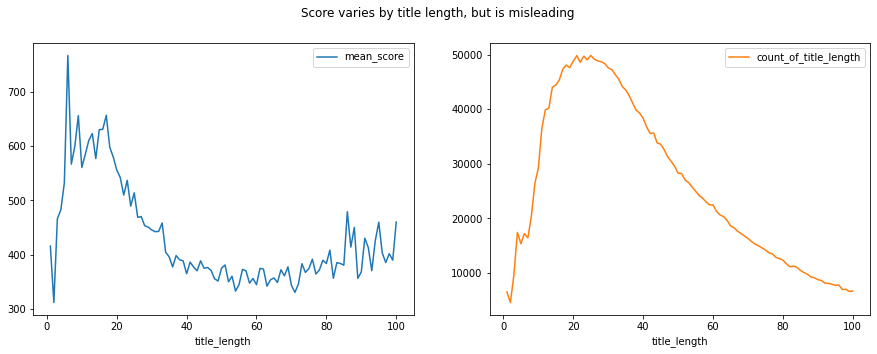

In [30]:
df_pd[df_pd['title_length'] <= 100.0].groupby('title_length').\
    agg(mean_score=('score', 'mean'),
        count_of_title_length=('title_length', 'count')).\
    plot(subplots=True, title="Score varies by title length, but is misleading",
         layout=(1, 2), figsize=(15, 5));

As can be seen, this view paints a different picture - the score is actually higher on average for lower title counts.

## Conclusions of exploration

From the above analyses, it is clear that treating score as a categorical variable will not yield satisfactory results - the score itself varies widely, with a median of $22$, and a range between $3$ and $230,000$. What can then be done is to create a model for the data that crosses a certain threshold - let's say, the top $50\%$ of posts, which have a score of $22$, and then bucket the score into specific groups.

In [45]:
df_pd_fs = df_pd.loc[lambda x:x.score >= 75]

In [30]:
#df_pd_fs['log_score_ratio']=np.log10(df_pd_fs['score']/df_pd_fs['subreddit_subscribers'])
#sns.histplot(x='log_score_ratio',data=df_pd_fs)
df_pd_fs.score.describe(percentiles=[0, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99])

count    735840.0000
mean       1710.5949
std        5895.7605
min          75.0000
0%           75.0000
25%         121.0000
50%         243.0000
75%         804.0000
90%        3417.0000
95%        7649.0000
99%       27558.2700
max      230972.0000
Name: score, dtype: float64

Based on the values above, the bins for the score can be created as so:

In [50]:
score_bins = [0, 75, 244, 3426, 1e6]
df_pd_fs['score_bin'] = pd.cut(
    df_pd_fs['score'], bins=score_bins, labels=['very_low', 'low', 'med', 'high'])

/tmp/ipykernel_6060/1719331131.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pd_fs['score_bin'] = pd.cut(


### Save final output to disk to reload as PySpark DataFrame

In [32]:
df_pd_fs.columns

Index(['author', 'subreddit', 'score', 'subreddit_subscribers', 'over_18',
       'num_crossposts', 'is_video', 'num_comments', 'is_self', 'domain',
       'is_crosspostable', 'is_original_content', 'total_awards_received',
       'upvote_ratio', 'author_flair_background_color', 'created_datetime',
       'is_media_embed', 'author_flair', 'title_length', 'created_timestamp',
       'created_date', 'created_time', 'created_weekday',
       'created_hour_of_day', 'score_bin'],
      dtype='object')

In [93]:
selected_cols = ['author', 'subreddit', 'subreddit_subscribers', 'over_18',
                 'num_crossposts', 'is_video', 'num_comments', 'is_self',
                 'domain', 'author_flair_background_color', 'author_flair',
                 'title_length', 'created_weekday', 'created_hour_of_day',
                 'score_bin']
df_pd_fs.loc[:, selected_cols].to_parquet("df_subset_01.parquet", compression="zstd", index=False)

In [3]:
DF_pd_fs = spark.read.parquet("df_subset_01.parquet")

In [34]:
DF_pd_fs.dtypes

[('author', 'string'),
 ('subreddit', 'string'),
 ('subreddit_subscribers', 'int'),
 ('over_18', 'boolean'),
 ('num_crossposts', 'int'),
 ('is_video', 'boolean'),
 ('num_comments', 'int'),
 ('is_self', 'boolean'),
 ('domain', 'string'),
 ('author_flair_background_color', 'string'),
 ('author_flair', 'string'),
 ('title_length', 'double'),
 ('created_weekday', 'string'),
 ('created_hour_of_day', 'bigint'),
 ('score_bin', 'string')]

# Modelling Using `spark.MLib`

## Preparing Data for Ingestion

Spark's `MLib` is absolutely sparse on documentation. It cannot handle string data, and so strings have to be "transformed" into numeric values. Reference for the following steps: [here](https://towardsdatascience.com/your-first-apache-spark-ml-model-d2bb82b599dd).

### `StringIndexer`

PySpark has a feature called `StringIndexer`, which encodes the string into numeric values. The reverse can also be performed via `IndexToString`.

In [5]:
from pyspark.ml.feature import StringIndexer

str_cols = ['author', 'subreddit', 'domain',
            'author_flair_background_color',
            'author_flair', 'created_weekday',
            'score_bin']

DF_pd_fs

def Str_Ind(DF, cols, suffix, drop=True):
    # Drop any columns not being StringIndexed
    if len(DF.columns) - len(cols) > 0:
        DF = DF.drop(*list(set(DF.columns) - set(cols)))
    DF = StringIndexer(
        inputCols=cols, 
        outputCols=[x+suffix for x in cols],
        handleInvalid='keep'
    ).fit(DF).transform(DF)
    if drop:
        return DF.drop(*cols)
    else:
        return DF

### `VectorAssembler`

For some godforsaken reason, PySpark also wants the features to be in a single column, stored as a vector of features in each individual row. This is achieved through the following code:

In [4]:
from pyspark.ml.feature import VectorAssembler

def Vec_Asb(DF, exclude_col, drop=True):
    required_cols = [x for x in DF.columns if x != exclude_col]
    DF = VectorAssembler(
        inputCols=required_cols, 
        outputCol="features",
        handleInvalid='keep'
    ).transform(DF)
    if drop:
        return DF.drop(*required_cols)
    else:
        return DF

### Preparing the Data for modelling and Test-Train Split

In [6]:
DF_str = Str_Ind(DF_pd_fs, str_cols, "_", True)
DF_new = DF_pd_fs.drop(*str_cols).withColumn("idx", monotonically_increasing_id())
DF_str = DF_str.withColumn("idx", monotonically_increasing_id())
DF_N = DF_str.join(DF_new,DF_str.idx==DF_new.idx,"inner")
DF_N=DF_N.drop('idx')

In [7]:
DF_N.show(1)

22/03/30 17:58:06 WARN DAGScheduler: Broadcasting large task binary with size 10.9 MiB
22/03/30 17:58:07 WARN DAGScheduler: Broadcasting large task binary with size 10.9 MiB


+--------+----------+-------+------------------------------+-------------+----------------+----------+---------------------+-------+--------------+--------+------------+-------+------------+-------------------+
| author_|subreddit_|domain_|author_flair_background_color_|author_flair_|created_weekday_|score_bin_|subreddit_subscribers|over_18|num_crossposts|is_video|num_comments|is_self|title_length|created_hour_of_day|
+--------+----------+-------+------------------------------+-------------+----------------+----------+---------------------+-------+--------------+--------+------------+-------+------------+-------------------+
|172655.0|    1092.0|    3.0|                         342.0|          0.0|             6.0|       0.0|               518086|  false|             0|   false|           4|  false|        55.0|                 22|
+--------+----------+-------+------------------------------+-------------+----------------+----------+---------------------+-------+--------------+--------+

In [8]:
DF_Model = Vec_Asb(DF_N, "score_bin_", True)
train,test = DF_Model.randomSplit([0.8,0.2])

### Creating an evaluation function for statistical models

In [25]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

def eval_multi(pred, label="score_bin_", metric="accuracy"):
    evaluator = MulticlassClassificationEvaluator(
        labelCol='score_bin_', 
        predictionCol='prediction', 
        metricName='accuracy')
    accuracy = evaluator.evaluate(pred)
    print(f'Test Accuracy = {accuracy:.2%}')

## Logistic Regression

In [100]:
from pyspark.ml.classification import LogisticRegression

In [101]:
lr = LogisticRegression(
    maxIter=50, regParam=0.3, elasticNetParam=0.8,
    featuresCol='features', labelCol='score_bin_')
lrModel = lr.fit(train)

22/03/30 17:51:23 WARN DAGScheduler: Broadcasting large task binary with size 12.5 MiB
22/03/30 17:51:32 WARN DAGScheduler: Broadcasting large task binary with size 12.5 MiB
22/03/30 17:51:42 WARN DAGScheduler: Broadcasting large task binary with size 12.5 MiB
22/03/30 17:51:44 WARN DAGScheduler: Broadcasting large task binary with size 12.5 MiB
22/03/30 17:51:45 WARN DAGScheduler: Broadcasting large task binary with size 12.5 MiB
22/03/30 17:51:46 WARN DAGScheduler: Broadcasting large task binary with size 12.5 MiB
22/03/30 17:51:48 WARN DAGScheduler: Broadcasting large task binary with size 12.5 MiB
22/03/30 17:51:49 WARN DAGScheduler: Broadcasting large task binary with size 12.5 MiB
22/03/30 17:51:51 WARN DAGScheduler: Broadcasting large task binary with size 12.5 MiB
22/03/30 17:51:52 WARN DAGScheduler: Broadcasting large task binary with size 12.5 MiB
22/03/30 17:51:54 WARN DAGScheduler: Broadcasting large task binary with size 12.5 MiB
22/03/30 17:51:56 WARN DAGScheduler: Broadc

### Logistic Regression Evaluation

In [103]:
pred = lrModel.transform(test)

In [104]:
eval_multi(pred)

22/03/30 17:54:51 WARN DAGScheduler: Broadcasting large task binary with size 12.6 MiB


Test Accuracy = 49.51%


## NaiveBayes Classifier


In [96]:
from pyspark.ml.classification import NaiveBayes

**_Create the NaiveBayes Model, using a smoothing of $100$ in an attempt to offset the lack of multiple records by all authors._**

In [97]:
nb = NaiveBayes(labelCol="score_bin_", featuresCol="features", smoothing=100, modelType="multinomial")
nb_Model = nb.fit(train)

22/03/30 17:50:45 WARN DAGScheduler: Broadcasting large task binary with size 12.5 MiB
22/03/30 17:50:55 WARN DAGScheduler: Broadcasting large task binary with size 12.5 MiB


### NaiveBayes Classifier Evaluation

In [98]:
pred = nb_Model.transform(test)
eval_multi(pred)

22/03/30 17:51:00 WARN DAGScheduler: Broadcasting large task binary with size 12.6 MiB


Test Accuracy = 25.53%


## Feed Forward Neural Net 

In [26]:
from pyspark.ml.classification import MultilayerPerceptronClassifier

In [27]:
layers = [14, 5, 4, 5]
trainer = MultilayerPerceptronClassifier(maxIter=100, layers=layers, seed=1234,featuresCol='features',labelCol='score_bin_')

# train the model
nn_model = trainer.fit(train)

22/03/30 18:09:21 WARN DAGScheduler: Broadcasting large task binary with size 12.6 MiB
22/03/30 18:09:30 WARN DAGScheduler: Broadcasting large task binary with size 12.6 MiB
22/03/30 18:09:31 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
22/03/30 18:09:31 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS
22/03/30 18:09:33 WARN DAGScheduler: Broadcasting large task binary with size 12.6 MiB
22/03/30 18:09:35 WARN DAGScheduler: Broadcasting large task binary with size 12.6 MiB
22/03/30 18:09:36 WARN DAGScheduler: Broadcasting large task binary with size 12.6 MiB
22/03/30 18:09:38 WARN DAGScheduler: Broadcasting large task binary with size 12.6 MiB
22/03/30 18:09:39 WARN DAGScheduler: Broadcasting large task binary with size 12.6 MiB
22/03/30 18:09:40 WARN DAGScheduler: Broadcasting large task binary with size 12.6 MiB
22/03/30 18:09:42 WARN DAGScheduler: Broadcasting large ta

In [29]:
pred = nn_model.transform(test)
eval_multi(pred)

22/03/30 18:10:59 WARN DAGScheduler: Broadcasting large task binary with size 12.6 MiB


Test Accuracy = 49.53%


## Random Forest Classifier

In [189]:
DF = Str_Ind(DF_pd_fs, [x for x in str_cols if x not in ['author', 'domain']], "_", True)
DF = Vec_Asb(DF, "score_bin_", True)
train,test = DF.randomSplit([0.8,0.2])

In [54]:
from pyspark.ml.classification import RandomForestClassifier 
rf = RandomForestClassifier(labelCol="score_bin_", featuresCol="features", numTrees=100, maxBins=1364)

Run the RandomForest model. This takes around an hour or more.

from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier(labelCol="score_bin_", featuresCol="features", numTrees=100, maxBins=1364)
rf_Model = rf.fit(train)

In [202]:
rf_Model.save("rf.model")

In [76]:
# rfeg = RandomForestClassifier.load("rf.model")

Accuracy isn't much better than a random guess model.

In [222]:
pred = rf_Model.transform(test)
eval_multi(pred)

22/03/24 05:59:39 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB


Test Accuracy = 50.41%
